## CORDIC Testbench


This notebook is to test the implementation of a CORDIC running on the programmable logic. The CORDIC is used to convert cartesian to polar coordinates. The output is compared with a Python calculation of the coordinate transform. It takes in x and y and gives out r and theta where r is the radius and theta is the angle.

In [18]:
from pynq import Overlay
from pynq import MMIO
import numpy as np
import struct
import binascii
import cmath
import random
import matplotlib.pyplot as plt

NUM_SAMPLES = 50

In [19]:
ol=Overlay('./cordic.bit') #Change name of bitstream as required

In [20]:
cordic_ip=MMIO(0x40000000,10000) #Change base address as required

In [21]:
r_error=np.zeros(NUM_SAMPLES)
theta_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
r_rmse=np.zeros(NUM_SAMPLES)
theta_rmse=np.zeros(NUM_SAMPLES)

In [22]:
# ---- choose FRAC to match your HLS ap_fixed<W,I> (FRAC = W - I) ----
FRAC  = 28
SCALE = 1 << FRAC

def to_fix32(f):
    val = int(round(f * SCALE))
    return val & 0xFFFFFFFF  # 32-bit two's complement

def from_fix32(u):
    u = int(u) & 0xFFFFFFFF
    if u & 0x80000000:        # sign-extend
        u -= 0x100000000
    return float(u) / SCALE

# Offsets you provided
X_OFF, Y_OFF, R_OFF, TH_OFF = 0x10, 0x18, 0x20, 0x30
CTRL = 0x00

r_error = [0.0]*NUM_SAMPLES
theta_error = [0.0]*NUM_SAMPLES

for i in range(NUM_SAMPLES):
    # 1) Generate float inputs and golden (use floats here!)
    xf = random.uniform(-1, 1)
    yf = random.uniform(-1, 1)
    cn = cmath.polar(complex(xf, yf))   # (r_golden, theta_golden)

    # 2) Convert floats -> fixed raw and write to registers
    cordic_ip.write(X_OFF, to_fix32(xf))
    cordic_ip.write(Y_OFF, to_fix32(yf))

    # 3) Start/stop (per framework)
    cordic_ip.write(CTRL, 1)
    cordic_ip.write(CTRL, 0)

    # 4) Read raw fixed words and convert back to float
    r     = from_fix32(cordic_ip.read(R_OFF))
    theta = from_fix32(cordic_ip.read(TH_OFF))

    # 5) Errors as floats (don't stringify yet)
    r_error[i]     = abs(r - cn[0])
    theta_error[i] = abs(theta - cn[1])

# RMSE (now works because arrays hold floats, not strings)
r_rmse     = np.sqrt(np.mean(np.square(r_error)))
theta_rmse = np.sqrt(np.mean(np.square(theta_error)))
print("Radius RMSE:", r_rmse, "Theta RMSE:", theta_rmse)
print("PASS" if (r_rmse < 1e-3 and theta_rmse < 1e-3) else "FAIL")



#for i in range(NUM_SAMPLES):
#    #Generating random inputs
#    x=random.uniform(-1,1)
#    y=random.uniform(-1,1)
    
#    #Computing golden output
#    cn=complex(x,y)
#    cn=cmath.polar(cn)
#    
#    #Converting input to bytes to be sent to FPGA
#    x=(struct.unpack('<I', struct.pack('<f', x))[0])
#    y=(struct.unpack('<I', struct.pack('<f', y))[0])
#    
#    #Writing values to the FPGA
#    cordic_ip.write(0x10,x)                             #Change the offset as mentioned in vivado file
#    cordic_ip.write(0x18,y)                             #Change the offset as mentioned in vivado file
#    
#    #Starting and stopping the IP (Don't change this)
#    cordic_ip.write(0x00,1)
#    cordic_ip.write(0x00,0)
#    
#    #Reading from IP
#    r=hex(cordic_ip.read(0x20))                         #Change the offset as mentioned in vivado file
#    r=r[2:]
#    theta=hex(cordic_ip.read(0x30))                     #Change the offset as mentioned in vivado file
#    theta=theta[2:]
#    
#    #Converting to float
#    if r!=0:
#        r=struct.unpack('>f', binascii.unhexlify(r))
#        r=r[0]
#    if theta!=0:
#        theta=struct.unpack('>f', binascii.unhexlify(theta))
#        theta=theta[0]
#    
#    print("r:"+r)
#    print("theta:"+theta)
#    #Comparing with golden output    
#    r_error[i]="{0:.6f}".format(abs(r-cn[0]))
#    theta_error[i]="{0:.6f}".format(abs(theta-cn[1]))

Radius RMSE: 3.516909794855573e-08 Theta RMSE: 0.00021434685335407783
PASS


## Verifying Functionality

In [23]:
sum_sq_r=0
sum_sq_theta=0
for i in range(NUM_SAMPLES):
    sum_sq_r =sum_sq_r+(r_error[i]*r_error[i])
    r_rmse = np.sqrt(sum_sq_r / (i+1))
    sum_sq_theta =sum_sq_theta+(theta_error[i]*theta_error[i])
    theta_rmse = np.sqrt(sum_sq_theta / (i+1))
print("Radius RMSE: ", r_rmse, "Theta RMSE:", theta_rmse)    
if r_rmse<0.001 and theta_rmse<0.001:
    print("PASS")
else:
    print("FAIL")

Radius RMSE:  3.516909794855574e-08 Theta RMSE: 0.00021434685335407783
PASS


## Displaying Errors

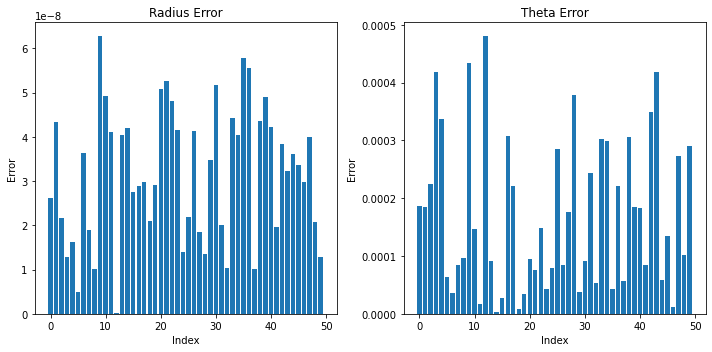

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,r_error)
plt.title("Radius Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,theta_error)
plt.title("Theta Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()